# Zip Code Tabulation Areas

In this notebook we will show how to download data at the Zip Code Tabulation Area (ZCTA) level.

[Zip Code Tabulation Areas](https://www.census.gov/programs-surveys/geography/guidance/geo-areas/zctas.html)
(ZCTAs) are not exactly zip codes, but they are close.
They are polygons that enclose areas containing home delivery locations within
a U.S. Postal Service Zip Code. Not all valid postal Zip Codes have a corresponding
ZCTA, because some are commercial and contain no residences. There are also some
uninhabited areas of the country that are not in any ZCTA. So a map of ZCTAs may have
holes in it or there may be small uninhabited areas between ZCTAs. ZCTAs also need
not be continuous. The link above contains additional details.

We will also demonstrate the change that the U.S. Census Bureau made to their
data model in 2020. Prior to that, zip code tabulation areas were nested inside of states.
But starting in 2020, zip code tabulation areas were at the top level
of the geography hierarchy. So we have to query them in a slightly different way
depending on what vintage we are interested in.

In [1]:
import censusdis.data as ced
import censusdis.maps as cem
from censusdis.datasets import ACS5
from censusdis.states import CO, AZ, ID, MT, NV, NM, UT, WY, ABBREVIATIONS_FROM_IDS, TX
from censusdis.places.texas import DALLAS_CITY

In [2]:
states = [CO, AZ, ID, MT, NV, NM, UT, WY]

state_abbrevs = [ABBREVIATIONS_FROM_IDS[state] for state in states]

In [3]:
# A dictionary to collect our results.
gdfs_by_year = {}

## Pre-2020

Prior to 2020, zip code tabulation areas were nested inside of states.
So we can query them with a normal call to `ced.download`. This is despite
the fact that some U.S. Postal zip codes and their corresponding ZCTAs
cross state lines. We will see that when we plot them a few cells from now.

In [4]:
for year in 2018, 2019:
    gdfs_by_year[year] = ced.download(
        ACS5,
        year,
        ["NAME"],
        state=states,
        zip_code_tabulation_area="*",
        with_geometry=True,
    )

## 2020 and Later

Starting in 2020, zip code tabulation areas were at the top level
of the geography hierarchy. So if we want to get only those contained
in certain states, then we have to use the `ced.contained_within().download()`
idiom. We want to see every zip code that intersects each state with even a tiny
portion of its area, so we will set the `area_threshold=0.001` argument to
overide the default value of `0.8`. Note that this newer data model more accurately
represents the relationship between ZCTAs and states, but at the expense of 
requiring more advanced query mechanics for some common queries, like all 
ZCTAs intersecting a state.

In [5]:
for year in 2020, 2022:
    gdfs_by_year[year] = ced.contained_within(
        state=states, area_threshold=0.001
    ).download(
        ACS5,
        year,
        ["NAME"],
        zip_code_tabulation_area="*",
        with_geometry=True,
    )

## Plot All Years

We will now plot the results of all the queries above on maps. It will become apparent that state
and ZCTA boundaries do not always coincide and that there are uninabited areas (sometimes quite large
ones) that are not a part of any ZCTA. This is especially true in large western states like the ones
we queried above.

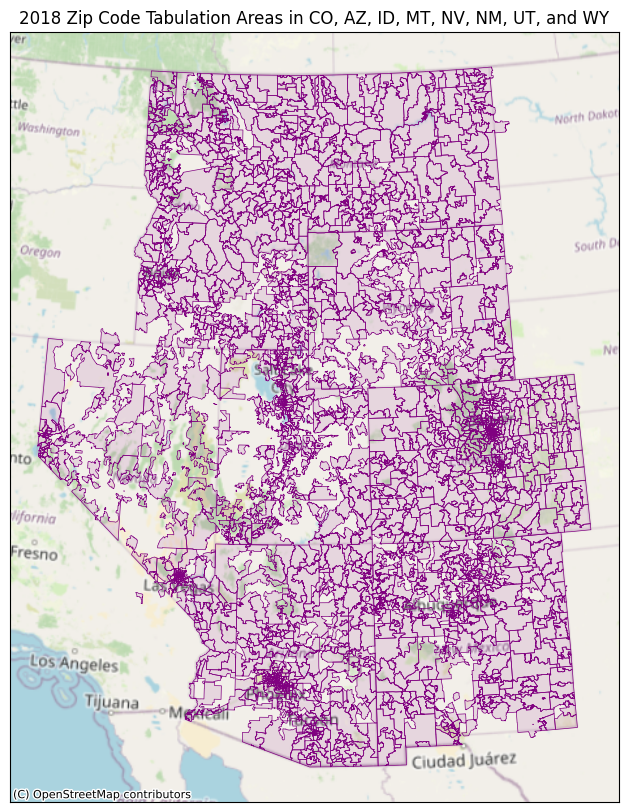

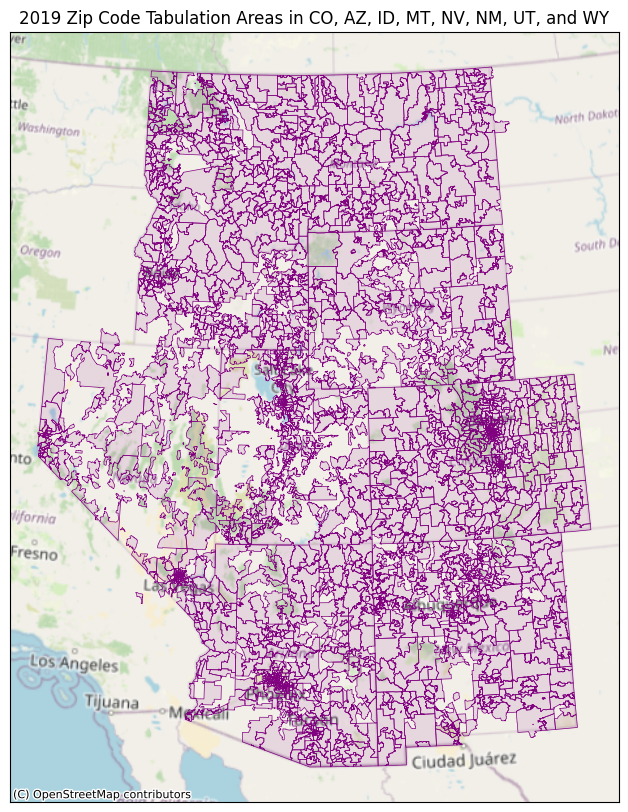

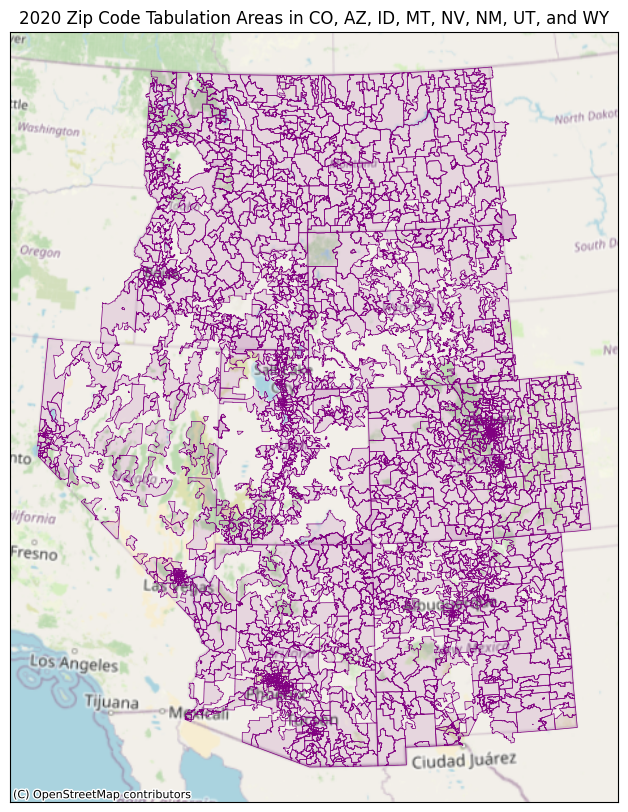

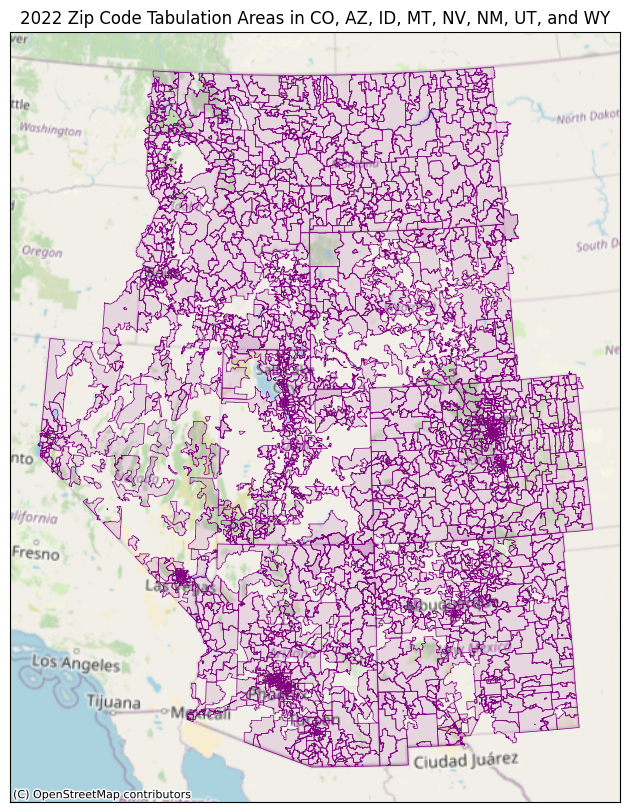

In [6]:
for year, gdf in gdfs_by_year.items():
    ax = cem.plot_map(
        gdf, color="purple", alpha=0.1, figsize=(10, 10), with_background=True
    )

    ax = cem.plot_map(gdf.boundary, color="purple", linewidth=0.5, ax=ax)

    ax.set_title(
        f'{year} Zip Code Tabulation Areas in {", and ".join([", ".join(state_abbrevs[:-1]), state_abbrevs[-1]])}'
    )

## ZCTAs "in" a City (Place)

Finally, let's look at a very common query people would like to do.
The query is, "what are all the zip codes in a city?"

First we have to transalate some terms to U.S. Census terminology. A
city is a "place" in most cases. And zip codes are, as we have seen,
approximated by ZCTAs.

We will again use the contained within idiom, but without specifying 
`area_threshold=`, so we will get the default 80%.

In cities, there are fewer uninhabited areas, and ZCTA boundaries tend to
more closely follow municiplal boundaries, but this is not always guaranteed
to be the case.

In [7]:
gdf_dallas_zctas = ced.contained_within(state=TX, place=DALLAS_CITY).download(
    ACS5,
    2023,
    ["NAME"],
    zip_code_tabulation_area="*",
    with_geometry=True,
)

Text(0.5, 1.0, '2023 Zip Code Tabulation Areas "in" Dallas, TX')

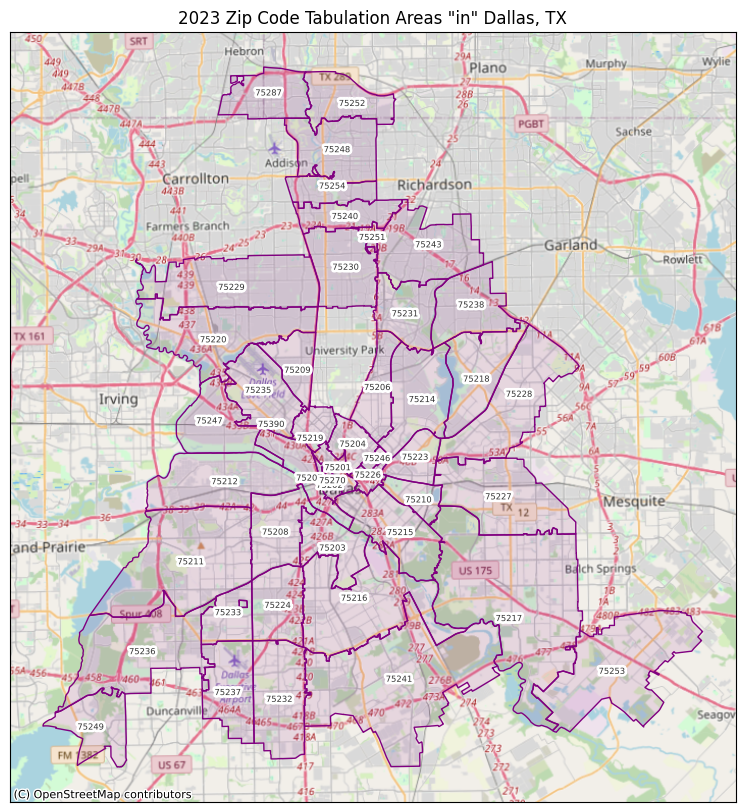

In [8]:
ax = cem.plot_map(
    gdf_dallas_zctas,
    color="purple",
    alpha=0.1,
    figsize=(10, 10),
    with_background=True,
    geo_label="ZIP_CODE_TABULATION_AREA",
    geo_label_text_kwargs={"size": 6},
)
ax = cem.plot_map(gdf_dallas_zctas.boundary, color="purple", linewidth=1.0, ax=ax)

ax.set_title('2023 Zip Code Tabulation Areas "in" Dallas, TX')